# CBOW in Keras
### Continuous Bag of Words
- tensorflow 2.0 코드 사용
- keras 위주로 되어 있어서 코드는 일부 수정만 하였음

In [16]:
import numpy as np

import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from keras.utils import np_utils
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer

import gensim
import nltk

from IPython.display import SVG

In [17]:
nltk.download('gutenberg')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\ckkim\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

In [18]:
 nltk.corpus.gutenberg.sents("carroll-alice.txt")[10]

['The',
 'rabbit',
 '-',
 'hole',
 'went',
 'straight',
 'on',
 'like',
 'a',
 'tunnel',
 'for',
 'some',
 'way',
 ',',
 'and',
 'then',
 'dipped',
 'suddenly',
 'down',
 ',',
 'so',
 'suddenly',
 'that',
 'Alice',
 'had',
 'not',
 'a',
 'moment',
 'to',
 'think',
 'about',
 'stopping',
 'herself',
 'before',
 'she',
 'found',
 'herself',
 'falling',
 'down',
 'a',
 'very',
 'deep',
 'well',
 '.']

In [19]:
sentents = [" ".join(s) for s in nltk.corpus.gutenberg.sents("carroll-alice.txt") if len(s) > 2]

In [20]:
sentents[10]

'The rabbit - hole went straight on like a tunnel for some way , and then dipped suddenly down , so suddenly that Alice had not a moment to think about stopping herself before she found herself falling down a very deep well .'

In [21]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentents)
corpus = tokenizer.texts_to_sequences(sentents)
nb_samples = sum(len(s) for s in corpus)
V = len(tokenizer.word_index) + 1
dim = 100
window_size = 2

In [22]:
def generate_data(corpus, window_size, V):
    maxlen = window_size*2
    for words in corpus:
        L = len(words)
        for index, word in enumerate(words):
            contexts = []
            labels = []
            s = index - window_size
            e = index + window_size + 1

            contexts.append([words[i] for i in range(s, e) if 0 <= i < L and i != index])
            labels.append(word)

            x = sequence.pad_sequences(contexts, maxlen=maxlen)
            y = np_utils.to_categorical(labels, V)
            yield (x, y)

In [23]:
X = []
Y = []
for x, y in generate_data(corpus, window_size, V):
    X.append(x)
    Y.append(y)

X = np.concatenate(X)
Y = np.concatenate(Y)

In [24]:
X.shape, Y.shape

((30179, 4), (30179, 2572))

In [25]:
X[2], np.nonzero(Y[2])

(array([ 12,   1, 475,  13]), (array([20], dtype=int64),))

In [26]:
X[3], np.nonzero(Y[3])

(array([  1,  20,  13, 831]), (array([475], dtype=int64),))

## Model

In [27]:
cbow = Sequential()
cbow.add(Embedding(input_dim=V, output_dim=dim, input_length=window_size*2))
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(dim,)))
cbow.add(Dense(V, activation='softmax'))
cbow.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 4, 100)            257200    
_________________________________________________________________
lambda_1 (Lambda)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2572)              259772    
Total params: 516,972
Trainable params: 516,972
Non-trainable params: 0
_________________________________________________________________


In [28]:
cbow.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=["accuracy"])

In [29]:
%time hist = cbow.fit(X, Y, epochs=50, batch_size=100, verbose=2)

Train on 30179 samples
Epoch 1/50
30179/30179 - 2s - loss: 7.8522 - accuracy: 3.6449e-04
Epoch 2/50
30179/30179 - 2s - loss: 7.8520 - accuracy: 4.3076e-04
Epoch 3/50
30179/30179 - 2s - loss: 7.8517 - accuracy: 4.6390e-04
Epoch 4/50
30179/30179 - 2s - loss: 7.8514 - accuracy: 5.6331e-04
Epoch 5/50
30179/30179 - 2s - loss: 7.8512 - accuracy: 7.9526e-04
Epoch 6/50
30179/30179 - 2s - loss: 7.8509 - accuracy: 0.0013
Epoch 7/50
30179/30179 - 2s - loss: 7.8507 - accuracy: 0.0020
Epoch 8/50
30179/30179 - 2s - loss: 7.8504 - accuracy: 0.0029
Epoch 9/50
30179/30179 - 2s - loss: 7.8501 - accuracy: 0.0050
Epoch 10/50
30179/30179 - 2s - loss: 7.8498 - accuracy: 0.0085
Epoch 11/50
30179/30179 - 2s - loss: 7.8496 - accuracy: 0.0151
Epoch 12/50
30179/30179 - 2s - loss: 7.8493 - accuracy: 0.0225
Epoch 13/50
30179/30179 - 2s - loss: 7.8490 - accuracy: 0.0314
Epoch 14/50
30179/30179 - 2s - loss: 7.8488 - accuracy: 0.0423
Epoch 15/50
30179/30179 - 2s - loss: 7.8485 - accuracy: 0.0508
Epoch 16/50
30179/301

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

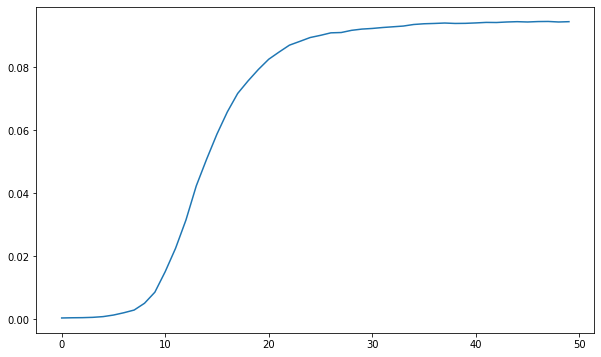

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(hist.history['accuracy'])    # TF1.x 에서는 acc
plt.show()